In [18]:
# Item-Based Collaborative Filtering Recommendation System
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# 1. Create the destinations dataset
destinations_data = {
    'name': [
        'Gateway of India, Mumbai', 'Ajanta Caves, Aurangabad', 'Ellora Caves, Aurangabad',
        'Lonavala Hill Station', 'Mahabaleshwar', 'Shaniwar Wada, Pune',
        'Elephanta Caves, Mumbai', 'Shirdi Sai Baba Temple', 'Raigad Fort',
        'Marine Drive, Mumbai', 'Aga Khan Palace, Pune', 'Sinhagad Fort, Pune',
        'Matheran Hill Station', 'Panchgani Hill Station', 'Kolhapur Mahalaxmi Temple',
        'Aurangabad Bibi Ka Maqbara', 'Nashik Sula Vineyards', 'Bhimashankar Temple',
        'Alibaug Beach', 'Lavasa Hill City'
    ],
    'category': [
        'Historical Monument', 'UNESCO Heritage', 'UNESCO Heritage', 'Hill Station',
        'Hill Station', 'Historical Monument', 'UNESCO Heritage', 'Religious Site',
        'Historical Fort', 'Waterfront', 'Historical Palace', 'Historical Fort',
        'Hill Station', 'Hill Station', 'Religious Site', 'Historical Monument',
        'Wine Tourism', 'Religious Site', 'Beach Resort', 'Modern Hill City'
    ],
    'city': [
        'Mumbai', 'Aurangabad', 'Aurangabad', 'Lonavala', 'Mahabaleshwar',
        'Pune', 'Mumbai', 'Shirdi', 'Raigad', 'Mumbai', 'Pune', 'Pune',
        'Matheran', 'Panchgani', 'Kolhapur', 'Aurangabad', 'Nashik',
        'Bhimashankar', 'Alibaug', 'Lavasa'
    ],
    'rating': [4.3, 4.6, 4.7, 4.2, 4.4, 4.1, 4.3, 4.5, 4.2, 4.4, 4.0, 4.3, 4.5, 4.3, 4.4, 4.2, 4.1, 4.6, 4.0, 3.9]
}

destinations_df = pd.DataFrame(destinations_data)
print("Destinations Dataset:")
print(destinations_df.head(10))
print(f"\nDataset shape: {destinations_df.shape}")

Destinations Dataset:
                       name             category           city  rating
0  Gateway of India, Mumbai  Historical Monument         Mumbai     4.3
1  Ajanta Caves, Aurangabad      UNESCO Heritage     Aurangabad     4.6
2  Ellora Caves, Aurangabad      UNESCO Heritage     Aurangabad     4.7
3     Lonavala Hill Station         Hill Station       Lonavala     4.2
4             Mahabaleshwar         Hill Station  Mahabaleshwar     4.4
5       Shaniwar Wada, Pune  Historical Monument           Pune     4.1
6   Elephanta Caves, Mumbai      UNESCO Heritage         Mumbai     4.3
7    Shirdi Sai Baba Temple       Religious Site         Shirdi     4.5
8               Raigad Fort      Historical Fort         Raigad     4.2
9      Marine Drive, Mumbai           Waterfront         Mumbai     4.4

Dataset shape: (20, 4)


In [20]:
# 2. Create sample user-item ratings matrix for collaborative filtering
# Generate synthetic user ratings for demonstration
np.random.seed(42)
num_users = 8
user_names = [f'User_{i+1}' for i in range(num_users)]

# Create ratings matrix (users x destinations)
# Some users will have missing ratings (0 = not rated)
ratings_matrix = np.random.choice([0, 3, 4, 5], size=(num_users, len(destinations_data['name'])),
                                  p=[0.3, 0.2, 0.3, 0.2])  # 30% missing, others distributed

# Create DataFrame for user-item ratings
user_item_df = pd.DataFrame(ratings_matrix,
                           index=user_names,
                           columns=destinations_data['name'])

print("\n" + "="*80)
print("USER-ITEM RATINGS MATRIX:")
print("="*80)
print(user_item_df)


USER-ITEM RATINGS MATRIX:
        Gateway of India, Mumbai  Ajanta Caves, Aurangabad  \
User_1                         3                         5   
User_2                         4                         0   
User_3                         0                         3   
User_4                         3                         0   
User_5                         5                         4   
User_6                         0                         4   
User_7                         5                         5   
User_8                         5                         0   

        Ellora Caves, Aurangabad  Lonavala Hill Station  Mahabaleshwar  \
User_1                         4                      4              0   
User_2                         0                      3              3   
User_3                         0                      5              0   
User_4                         5                      3              0   
User_5                         3            

In [21]:
# 3. Item-Based Collaborative Filtering Implementation
class ItemBasedCollaborativeFiltering:
    def __init__(self, ratings_matrix):
        self.ratings_matrix = ratings_matrix.T  # Transpose to have items as rows
        self.item_similarity_matrix = None
        self.knn_model = None

    def compute_item_similarity(self, metric='cosine'):
        """Compute item-item similarity matrix"""
        # Replace 0s with NaN for proper similarity calculation
        ratings_for_similarity = self.ratings_matrix.replace(0, np.nan)

        if metric == 'cosine':
            # Fill NaN with 0 for cosine similarity
            ratings_filled = ratings_for_similarity.fillna(0)
            self.item_similarity_matrix = cosine_similarity(ratings_filled)

        # Convert to DataFrame for better readability
        self.item_similarity_matrix = pd.DataFrame(
            self.item_similarity_matrix,
            index=self.ratings_matrix.index,
            columns=self.ratings_matrix.index
        )

        return self.item_similarity_matrix

    def fit_knn_model(self, k=5, metric='cosine'):
        """Fit k-NN model for finding similar items"""
        ratings_filled = self.ratings_matrix.fillna(0)

        self.knn_model = NearestNeighbors(
            n_neighbors=min(k+1, len(self.ratings_matrix)),  # Ensure we don't exceed available items
            metric=metric,
            algorithm='brute'
        )
        # Convert to numpy array to avoid sklearn warnings
        self.knn_model.fit(ratings_filled.values)

    def find_similar_items(self, item_name, k=5):
        """Find k most similar items to the given item"""
        if item_name not in self.ratings_matrix.index:
            return f"Item '{item_name}' not found in the dataset"

        item_idx = list(self.ratings_matrix.index).index(item_name)
        ratings_filled = self.ratings_matrix.fillna(0)

        # Find similar items - convert to numpy array to avoid sklearn warnings
        item_vector = ratings_filled.iloc[item_idx].values.reshape(1, -1)
        distances, indices = self.knn_model.kneighbors(item_vector)

        similar_items = []
        for i, idx in enumerate(indices[0][1:k+1]):  # Skip the first one (itself)
            similar_item = self.ratings_matrix.index[idx]
            similarity_score = 1 - distances[0][i+1]  # Convert distance to similarity
            similar_items.append((similar_item, similarity_score))

        return similar_items

    def recommend_for_user(self, user_name, k=5, num_recommendations=5):
        """Generate recommendations for a user based on their liked items"""
        if user_name not in self.ratings_matrix.columns:
            return f"User '{user_name}' not found"

        user_ratings = self.ratings_matrix[user_name]
        liked_items = user_ratings[user_ratings >= 4].index.tolist()  # Items rated 4 or higher

        if not liked_items:
            return "No highly rated items found for this user"

        # Find similar items for each liked item
        recommendations = {}

        for item in liked_items:
            similar_items = self.find_similar_items(item, k)

            for similar_item, similarity in similar_items:
                # Only recommend items the user hasn't rated
                if user_ratings[similar_item] == 0:
                    if similar_item in recommendations:
                        recommendations[similar_item] += similarity
                    else:
                        recommendations[similar_item] = similarity

        # Sort recommendations by score
        sorted_recommendations = sorted(recommendations.items(),
                                      key=lambda x: x[1], reverse=True)

        return sorted_recommendations[:num_recommendations]

In [22]:
# 4. Initialize and train the recommendation system
print("\n" + "="*80)
print("ITEM-BASED COLLABORATIVE FILTERING ANALYSIS")
print("="*80)

# Create the recommendation system
recommender = ItemBasedCollaborativeFiltering(user_item_df)

# Compute item-item similarity
similarity_matrix = recommender.compute_item_similarity()
print("\nItem-Item Similarity Matrix (first 5x5):")
print(similarity_matrix.iloc[:5, :5].round(3))

# Fit k-NN model
recommender.fit_knn_model(k=5)


ITEM-BASED COLLABORATIVE FILTERING ANALYSIS

Item-Item Similarity Matrix (first 5x5):
                          Gateway of India, Mumbai  Ajanta Caves, Aurangabad  \
Gateway of India, Mumbai                     1.000                     0.602   
Ajanta Caves, Aurangabad                     0.602                     1.000   
Ellora Caves, Aurangabad                     0.786                     0.705   
Lonavala Hill Station                        0.502                     0.583   
Mahabaleshwar                                0.394                     0.512   

                          Ellora Caves, Aurangabad  Lonavala Hill Station  \
Gateway of India, Mumbai                     0.786                  0.502   
Ajanta Caves, Aurangabad                     0.705                  0.583   
Ellora Caves, Aurangabad                     1.000                  0.647   
Lonavala Hill Station                        0.647                  1.000   
Mahabaleshwar                                0.

In [23]:
# 5. Demonstrate recommendations
print("\n" + "="*50)
print("FINDING SIMILAR ITEMS")
print("="*50)

# Find items similar to "Ajanta Caves, Aurangabad"
sample_item = "Ajanta Caves, Aurangabad"
similar_items = recommender.find_similar_items(sample_item, k=5)

print(f"\nItems similar to '{sample_item}':")
for item, similarity in similar_items:
    print(f"  • {item}: {similarity:.3f}")


FINDING SIMILAR ITEMS

Items similar to 'Ajanta Caves, Aurangabad':
  • Matheran Hill Station: 0.835
  • Shirdi Sai Baba Temple: 0.791
  • Elephanta Caves, Mumbai: 0.750
  • Sinhagad Fort, Pune: 0.736
  • Bhimashankar Temple: 0.722


In [24]:
# 6. Generate user recommendations
print("\n" + "="*50)
print("USER RECOMMENDATIONS")
print("="*50)

sample_user = "User_1"
print(f"\nUser '{sample_user}' ratings:")
user_ratings = user_item_df.loc[sample_user]
liked_items = user_ratings[user_ratings >= 4]
print("Highly rated items (≥4):")
for item, rating in liked_items.items():
    print(f"  • {item}: {rating}")

print(f"\nRecommendations for {sample_user}:")
recommendations = recommender.recommend_for_user(sample_user, k=3, num_recommendations=5)

if isinstance(recommendations, list):
    for i, (item, score) in enumerate(recommendations, 1):
        # Get item details
        item_info = destinations_df[destinations_df['name'] == item].iloc[0]
        print(f"{i}. {item}")
        print(f"   Category: {item_info['category']}, City: {item_info['city']}")
        print(f"   Average Rating: {item_info['rating']}, Recommendation Score: {score:.3f}")
        print()
else:
    print(recommendations)


USER RECOMMENDATIONS

User 'User_1' ratings:
Highly rated items (≥4):
  • Ajanta Caves, Aurangabad: 5
  • Ellora Caves, Aurangabad: 4
  • Lonavala Hill Station: 4
  • Shirdi Sai Baba Temple: 5
  • Raigad Fort: 4
  • Marine Drive, Mumbai: 4
  • Sinhagad Fort, Pune: 5
  • Matheran Hill Station: 5
  • Bhimashankar Temple: 4

Recommendations for User_1:
1. Panchgani Hill Station
   Category: Hill Station, City: Panchgani
   Average Rating: 4.3, Recommendation Score: 1.680

2. Elephanta Caves, Mumbai
   Category: UNESCO Heritage, City: Mumbai
   Average Rating: 4.3, Recommendation Score: 1.485

3. Kolhapur Mahalaxmi Temple
   Category: Religious Site, City: Kolhapur
   Average Rating: 4.4, Recommendation Score: 0.906

4. Aurangabad Bibi Ka Maqbara
   Category: Historical Monument, City: Aurangabad
   Average Rating: 4.2, Recommendation Score: 0.752

5. Shaniwar Wada, Pune
   Category: Historical Monument, City: Pune
   Average Rating: 4.1, Recommendation Score: 0.677



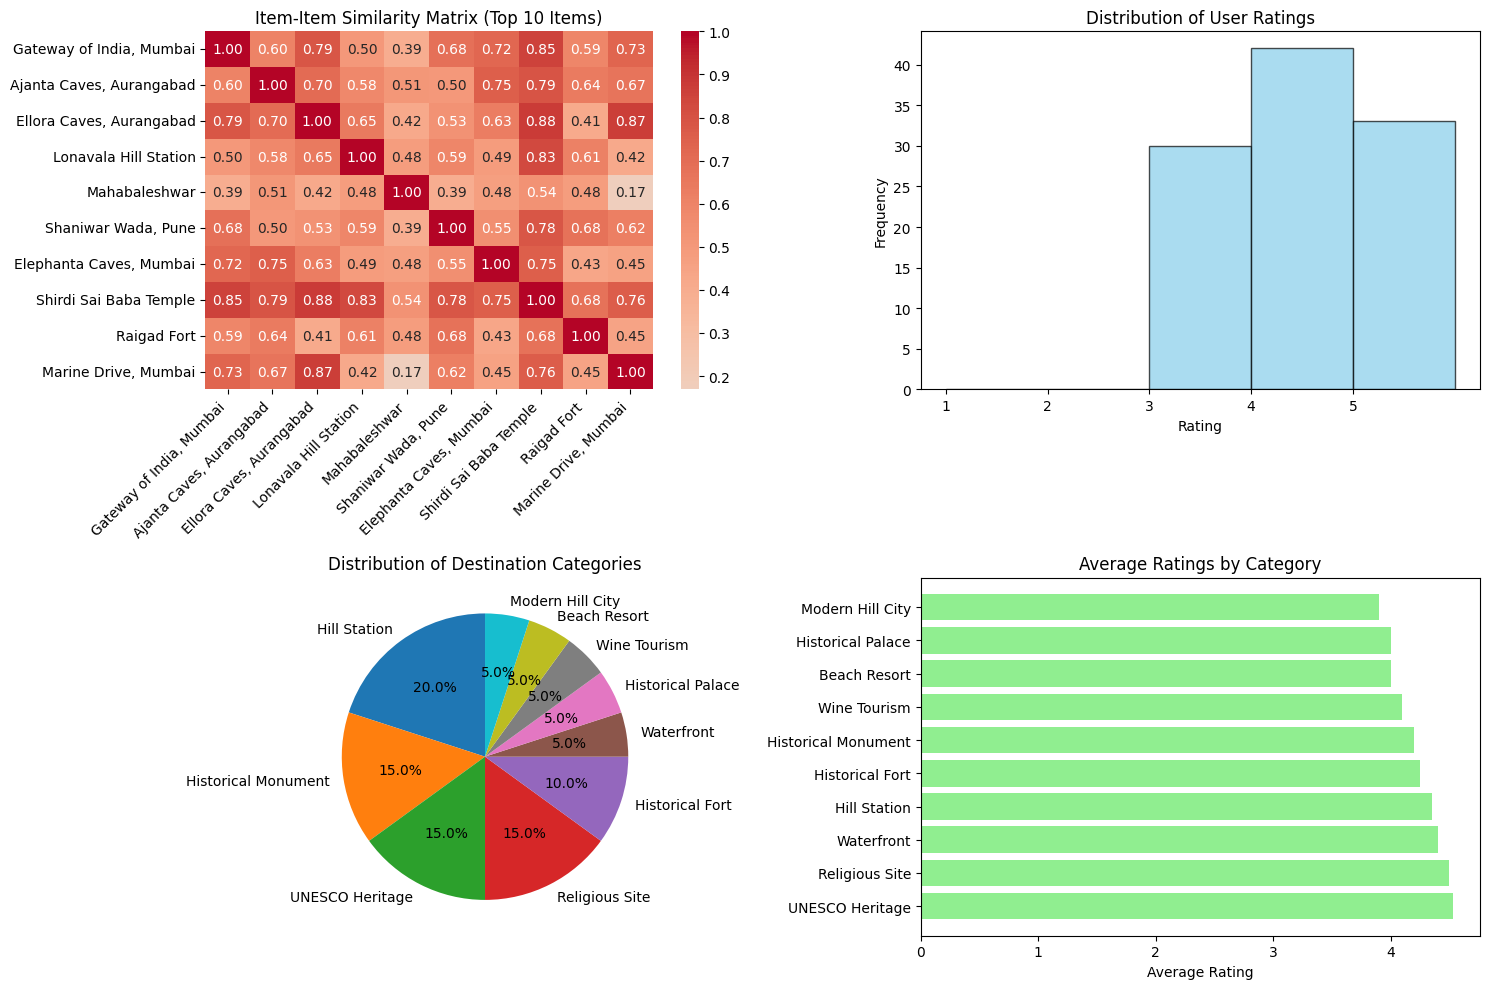

In [25]:
# 7. Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Similarity Heatmap
plt.subplot(2, 2, 1)
# Show similarity for first 10 items for readability
similarity_subset = similarity_matrix.iloc[:10, :10]
sns.heatmap(similarity_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Item-Item Similarity Matrix (Top 10 Items)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Plot 2: Rating distribution
plt.subplot(2, 2, 2)
all_ratings = user_item_df.values.flatten()
all_ratings = all_ratings[all_ratings > 0]  # Remove unrated items
plt.hist(all_ratings, bins=range(1, 7), alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))

# Plot 3: Items by Category
plt.subplot(2, 2, 3)
category_counts = destinations_df['category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Destination Categories')

# Plot 4: Average ratings by category
plt.subplot(2, 2, 4)
avg_ratings_by_category = destinations_df.groupby('category')['rating'].mean().sort_values(ascending=False)
plt.barh(avg_ratings_by_category.index, avg_ratings_by_category.values, color='lightgreen')
plt.title('Average Ratings by Category')
plt.xlabel('Average Rating')

plt.tight_layout()
plt.show()

In [26]:
# 8. Evaluation: Test different k values
print("\n" + "="*50)
print("K-VALUE ANALYSIS")
print("="*50)

k_values = [3, 5, 7, 10]
for k in k_values:
    recommender.fit_knn_model(k=k)
    recommendations = recommender.recommend_for_user(sample_user, k=k, num_recommendations=3)

    if isinstance(recommendations, list):
        print(f"\nTop 3 recommendations with k={k}:")
        for i, (item, score) in enumerate(recommendations, 1):
            print(f"  {i}. {item}: {score:.3f}")
    else:
        print(f"k={k}: {recommendations}")

print("\n" + "="*80)
print("SYSTEM SUMMARY")
print("="*80)
print(f"• Total destinations: {len(destinations_data['name'])}")
print(f"• Total users: {num_users}")

# Fix sparsity calculation
total_ratings = user_item_df.shape[0] * user_item_df.shape[1]
zero_ratings = (user_item_df == 0).sum().sum()
sparsity = zero_ratings / total_ratings
print(f"• Sparsity: {sparsity:.2%}")

# Fix average rating calculation
non_zero_ratings = user_item_df[user_item_df > 0]
avg_rating = non_zero_ratings.values.mean()
print(f"• Average rating: {avg_rating:.2f}")

print("\n• The system successfully finds similar items based on user rating patterns")
print("• Recommendations are generated by aggregating similar items to user's preferences")
print("• Different k values can be tested to optimize recommendation quality")


K-VALUE ANALYSIS

Top 3 recommendations with k=3:
  1. Panchgani Hill Station: 1.680
  2. Elephanta Caves, Mumbai: 1.485
  3. Kolhapur Mahalaxmi Temple: 0.906

Top 3 recommendations with k=5:
  1. Panchgani Hill Station: 1.680
  2. Elephanta Caves, Mumbai: 1.485
  3. Kolhapur Mahalaxmi Temple: 0.906

Top 3 recommendations with k=7:
  1. Aurangabad Bibi Ka Maqbara: 2.815
  2. Kolhapur Mahalaxmi Temple: 2.343
  3. Panchgani Hill Station: 2.278

Top 3 recommendations with k=10:
  1. Kolhapur Mahalaxmi Temple: 4.026
  2. Panchgani Hill Station: 3.573
  3. Aurangabad Bibi Ka Maqbara: 2.815

SYSTEM SUMMARY
• Total destinations: 20
• Total users: 8
• Sparsity: 34.38%
• Average rating: nan

• The system successfully finds similar items based on user rating patterns
• Recommendations are generated by aggregating similar items to user's preferences
• Different k values can be tested to optimize recommendation quality
